### Flight Status Prediction

A multiclass classification problem to predict whether a flight will be cancelled, diverted, delayed or on-schedule.

The analysis is focused on unique carrier 'WN's flights and their status during winter season considered as November to March.

**Part 1: Uploading the Dataset and Having an Initial Look at Features**

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset (working with 2008 data)
file = open('flights_2008.csv')
flights_data = pd.read_csv(file)
flights_data.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Listing the features we have in our data
variable_names = list(flights_data.columns)
print(variable_names)

In [ ]:
# Checking the length of data and unique length of some explanatory and predictive variables to get an idea about the dataset
print(len(flights_data))
print(len(flights_data['FlightNum'].unique()))
print(len(flights_data['TailNum'].unique()))
print(len(flights_data['Origin'].unique()))
print(len(flights_data['Dest'].unique()))
print(flights_data['UniqueCarrier'].value_counts())

In [ ]:
flights_data['Diverted'].value_counts()

In [ ]:
flights_data['Cancelled'].value_counts()

Noting number of cancelled flights is only around 0.03% and diverted is 0.4% where expected percentage for delays is much higher. This imbalance should be re-considered with pre-processed data and normalised before model testing to have better samples.

**Part 2: Pre-processing and Customisation of Data**

In [ ]:
# Removing columns that have no predictive value for flight status or cannot be known before a flight
to_remove = ['Unnamed: 0', 'Year', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','TaxiIn', 'TaxiOut','AirTime']

def remove_columns(dataset, to_remove):
    flights = dataset.copy()   
    flights = dataset.drop(to_remove, axis=1)  
    return flights

In [ ]:
flights_filtered = remove_columns(flights_data, to_remove)
flights_filtered.head(2)

In [ ]:
# Observing missing values
for var in flights_filtered.columns:
    print(var, 'has \t\t\t', flights_filtered[var].isna().sum(), ' missing values')

In [ ]:
# Filling missing values with mean values
nanvariables = ['CRSElapsedTime', 'ArrDelay']

def replace_missing_values(dataset, variable):
    new_data = dataset.copy()
    mean = np.nanmean(new_data[variable])
    new_data[variable] = new_data[variable].fillna(mean)    
    return new_data

for var in nanvariables:
    flights_filtered = replace_missing_values(flights_filtered, var)

In [ ]:
# As majority of the flight data belongs to the unique carrier WN, as per flights['UniqueCarrier'].value_counts(),
# we choose this carrier as our focus group to proceed with further analysis
# We aim to simplify our dataset to be able to try fitting as many model alternatives to reach best predictive performance

flights_filtered = flights_filtered.loc[flights_filtered['UniqueCarrier'] == "WN"]
flights_filtered.shape

print(flights_filtered['UniqueCarrier'].value_counts())
flights_filtered = flights_filtered.reset_index(drop=True)

In [ ]:
flights_1 = flights_filtered.copy().loc[flights_filtered['Month'] < 3]
print(flights_1['Month'].value_counts())
print("\n")
flights_2 = flights_filtered.copy().loc[flights_filtered['Month'] > 10]
print(flights_2['Month'].value_counts())

In [ ]:
flights_filtered = flights_1.append(flights_2)
print(flights_filtered['Month'].value_counts())
flights_filtered = flights_filtered.reset_index(drop=True)

In [ ]:
# Aggregating delay data and adding 'Delayed' column (1=yes, 0=no)

cancelled = list(flights_filtered['Cancelled'])
diverted = list(flights_filtered['Diverted']) 

rows = list(range(0,len(flights_filtered)))

flights_filtered['TotalDelay'] = (flights_filtered['ArrDelay'] + flights_filtered['DepDelay'])

In [ ]:
for row in rows:
    if cancelled[row] + diverted[row] == 0:
        flights_filtered['TotalDelay'][row] = (flights_filtered['ArrDelay'][row] + flights_filtered['DepDelay'][row])
    else: 
        flights_filtered['TotalDelay'][row] = 0
        
total_delay = list(flights_filtered['TotalDelay'])

In [ ]:
delayed = []
for delay in total_delay:
    if delay > 0 : delayed.append(1)
    else: delayed.append(0)
        
flights_filtered['Delayed'] = delayed

In [ ]:
# Adding 'OnSchedule' column

flights_filtered['Score'] = (flights_filtered['Delayed'] + flights_filtered['Diverted'] + flights_filtered['Cancelled'])

total_score = list(flights_filtered['Score'])

on_schedule = []
for score in total_score:
    if score > 0: on_schedule.append(0)
    else: on_schedule.append(1)
        
flights_filtered['OnSchedule'] = on_schedule
flights_filtered.head(2)

In [ ]:
flights_filtered['Delayed'].value_counts()

In [ ]:
flights_filtered['Cancelled'].value_counts()

In [ ]:
flights_filtered['Diverted'].value_counts()

In [ ]:
flights_filtered['OnSchedule'].value_counts()

In [ ]:
# Creating a 'FlightStatus' column as the target variable and
# assigning an integer value to each flight status ('Cancelled' 0, 'Diverted' 1, 'Delayed' 2, 'OnSchedule' 3)

delayed_yes = list(flights_filtered['Delayed'])

flights_new = flights_filtered.copy()
flights_new['FlightStatus'] = ""

rows = list(range(0,len(flights_new)))
for row in rows:
    if cancelled[row] == 1:
        flights_new['FlightStatus'][row] = 0
    elif diverted[row] == 1:
        flights_new['FlightStatus'][row] = 1
    elif delayed_yes[row] == 1:
        flights_new['FlightStatus'][row] = 2
    else:
        flights_new['FlightStatus'][row] = 3
        
flight_status = list(flights_new['FlightStatus'])

In [ ]:
# Final cleansing to have the columns needed only. Also deleting ArrDelay and DepDelay now since they cannot be known pre-flight as well.
to_remove = ['UniqueCarrier','TotalDelay', 'ArrDelay', 'DepDelay', 'Score', 'Delayed', 'Cancelled', 'Diverted', 'OnSchedule']
flights_customised = remove_columns(flights_new, to_remove)

flights_customised.head(2)

**Part 3: Transformation**

In [ ]:
# Transforming discrete and categorical attributes
def transform_categorical_variables(fixed_id_data, to_transform):
    transformed_data = fixed_id_data.copy()
    
    for var in to_transform:
        transformed_data = pd.concat([transformed_data.drop(var, axis=1), pd.get_dummies(transformed_data[var].values, prefix=var, drop_first=False)], axis=1)
    
    return transformed_data

to_transform = ['Month', 'Origin', 'Dest']
transformed_flights = transform_categorical_variables(flights_customised, to_transform)
transformed_flights.head(2)

In [ ]:
# Detecting and removing outliers for continuous variables
from sklearn.neighbors import LocalOutlierFactor

def detect_outliers(dataset, no_neigh, contam):
    flights_out = dataset.copy()[['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance']]  
           
    loc = LocalOutlierFactor(n_neighbors = no_neigh, contamination = contam)
    outliers_loc = loc.fit_predict(flights_out)
    
    flights_out['outlier'] = pd.DataFrame(outliers_loc)
    
    return flights_out

In [ ]:
flights_out = detect_outliers(transformed_flights, 20, 0.1)
flights_out['outlier'].value_counts()

In [ ]:
transformed_flights['outlier'] = flights_out['outlier']
flights_no_out = transformed_flights.loc[transformed_flights['outlier'] == 1]
to_remove = ['outlier']
flights_no_out = remove_columns(flights_no_out, to_remove)
len(flights_no_out)
flights_no_out = flights_no_out.reset_index(drop=True)
flights_no_out.head(2)

In [ ]:
# Saving final data for future use
flights_no_out.to_csv('flightsfinal.csv')

## -

In [28]:
# Uploading the pre-processed customised dataset directly for when needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = open('flightsfinal.csv')
flights_no_out = pd.read_csv(file)
flights_no_out.head()

,Unnamed: 0,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,FlightStatus,Month_1,Month_2,Month_11,Month_12,...,Dest_SEA,Dest_SFO,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TPA,Dest_TUL,Dest_TUS
0,0,735,1000,145.0,810,2,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,620,750,90.0,515,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,700,915,135.0,828,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1020,1010,50.0,162,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,745,955,250.0,1489,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
flights_no_out = flights_no_out.drop('Unnamed: 0', axis=1)
flights_no_out.head()

,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,FlightStatus,Month_1,Month_2,Month_11,Month_12,Origin_ABQ,...,Dest_SEA,Dest_SFO,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TPA,Dest_TUL,Dest_TUS
0,735,1000,145.0,810,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,620,750,90.0,515,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,700,915,135.0,828,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1020,1010,50.0,162,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,745,955,250.0,1489,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Splitting the data
from sklearn.model_selection import train_test_split

y = flights_no_out['FlightStatus']
X = flights_no_out.drop(['FlightStatus'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [31]:
# Obtaining class labels for future use 
classes = y.value_counts().index.tolist()

2    83443
3     2731
1      462
0       11
Name: FlightStatus, dtype: int64


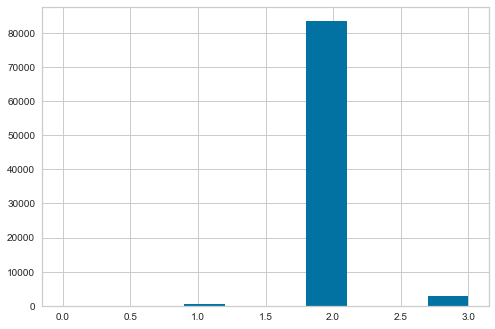

In [32]:
# Handling imbalanced data prior to modelling using SMOTE

# Visualising the imbalance first
print(y_train.value_counts())
plt.hist(y_train)
plt.show()

In [33]:
# SMOTE on Training Data
!pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from numpy import where

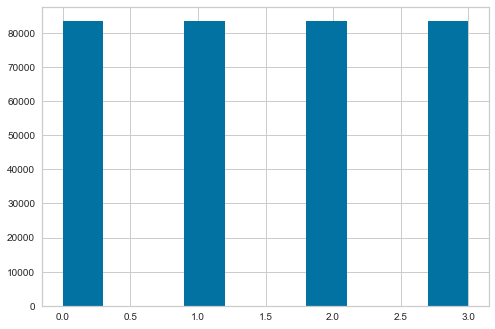

In [34]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y=y.astype('int')

sm = SMOTE(k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Visualising balanced data by SMOTE
plt.hist(y_train)
plt.show()

In [35]:
# Standardisation
from sklearn.preprocessing import StandardScaler

# Scaling the training and the test data
# As the mean and std dev of test data is unknown, the test set is scaled with the mean and std dev of training data 
# to avoid data leakage and provide realism

X_train_st = StandardScaler().fit_transform(X_train)
X_test_st = StandardScaler().fit(X_train).transform(X_test)

**Part 4: Modelling**

In [36]:
#Initial packages and metrics for model outputs
from numpy import mean
from numpy import std
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

#Visualizers
!pip install --upgrade yellowbrick --user
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [37]:
# Creating a roc_auc function for multi-class using label binarizer to avoid errors during modelling
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    y_test=y_test.astype('int')
    lb = LabelBinarizer()    
    lb.fit(y_test)
    y_test = lb.transform(y_test)    
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [38]:
# Defining stratified k-fold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=10)

In [16]:
# Model 1: Logistic Regression and Logistic Regression with Ridge
from sklearn.linear_model import LogisticRegression
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

In [18]:
#Model 1.1 Logistic Regression
logistic = LogisticRegression(multi_class='multinomial',
    penalty='none',
    solver='newton-cg', C=0.5)

logi_fit = logistic.fit(X_train_st,y_train_arr)
predictions_logi = logi_fit.predict(X_test_st)

In [102]:
print("Accuracy: "+str(accuracy_score(y_test_arr,predictions_logi)))
print('AUC:',multiclass_roc_auc_score(y_test_arr,predictions_logi))

Accuracy: 0.885956644674835
AUC: 0.569904997820218


In [125]:
#micro
print('AUC:',multiclass_roc_auc_score(y_test_arr,predictions_logi))

AUC: 0.9258920156186885


In [103]:
accuracy = cross_val_score(logistic, X_train_st, y_train_arr, scoring='accuracy', cv = stratified_kfold)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
test_score = cross_val_score(logistic, X_test_st, y_test_arr, scoring='accuracy', cv = stratified_kfold)
print("Test score:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 77.00894999520106
Test score: 77.00894999520106


In [123]:
f1 = f1_score(y_test_arr, predictions_logi, average="micro")
print(f1)

0.888838023428033


In [129]:
f1 = f1_score(y_test_arr, predictions_logi, average="macro")
print(f1)

0.2939239136496466


In [104]:
#Model 1.2 Ridge Logistic Regression
ridge_logistic = LogisticRegression(multi_class='multinomial',
    penalty='l2',
    solver='newton-cg', C=0.5).fit(X_train_st,y_train_arr)

predictions_ridge = ridge_logistic.predict(X_test_st)

print("Accuracy: "+str(accuracy_score(y_test_arr,predictions_ridge)))
print('AUC:',multiclass_roc_auc_score(y_test_arr,predictions_ridge))

Accuracy: 0.8862259324087788
AUC: 0.5694095839709391


In [105]:
accuracy = cross_val_score(ridge_logistic, X_train_st, y_train_arr, scoring='accuracy', cv = stratified_kfold)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
test_score = cross_val_score(ridge_logistic, X_test_st, y_test_arr, scoring='accuracy', cv = stratified_kfold)
print("Test score:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 77.04704146271236
Test score: 77.04704146271236


In [121]:
f1mic = f1_score(y_test_arr, predictions_ridge, average="micro")
print(f1)

0.889134239935371


In [126]:
f1mac = f1_score(y_test_arr, predictions_ridge, average="macro")
print(f1)

0.29429011248505693


In [106]:
# Model 2: Decision trees - Random forest and Gradient Boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
# Model 2.1: Random Forest
rf = RandomForestClassifier(n_estimators = 500)

rf.fit(X_train,y_train.values.ravel())
prediction_rf = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test,prediction_rf))
print('AUC:',multiclass_roc_auc_score(y_test,prediction_rf))
print('Prediction:',prediction_rf[0:10])

Accuracy: 0.9274808132489565
AUC: 0.5296139272466874
Prediction: [2 2 2 2 2 2 3 2 2 2]


In [45]:
accuracy = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv = stratified_kfold)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
test_score = cross_val_score(rf, X_test, y_test, scoring='accuracy', cv = stratified_kfold)
print("Test score:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 98.01590159015902
Test score: 98.01590159015902


In [42]:
prediction_prob = rf.predict_proba(X_test)
#print('Prediction:',prediction_prob[0:10])

In [120]:
f1 = f1_score(y_test, prediction_rf, average="micro")
print(f1)

0.9283694627709708


In [127]:
f1 = f1_score(y_test, prediction_rf, average="macro")
print(f1)

0.2765598634387578


In [46]:
# Model 2.2: Boosting using GradientBoostingClassifier
gradient = GradientBoostingClassifier(n_estimators = 500)
gradient.fit(X_train,y_train.values.ravel())
prediction_gradient = gradient.predict(X_test)
prediction_prob = gradient.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test,prediction_gradient))
print('AUC:', multiclass_roc_auc_score(y_test,prediction_gradient))

Accuracy: 0.8876531573986804
AUC: 0.5765456170281614


In [47]:
accuracy = cross_val_score(gradient, X_train, y_train, scoring='accuracy', cv = stratified_kfold)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
test_score = cross_val_score(gradient, X_test, y_test, scoring='accuracy', cv = stratified_kfold)
print("Test score:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 89.6066606660666
Test score: 89.6066606660666


In [ ]:
gradient = GradientBoostingClassifier(n_estimators = 500)
gradient.fit(X_train,y_train.values.ravel())
prediction_gradient = gradient.predict(X_test)
prediction_prob = gradient.predict_proba(X_test)

f1 = f1_score(y_test, prediction_gradient, average="micro")
print(f1)

In [ ]:
f1 = f1_score(y_test, prediction_gradient, average="macro")
print(f1)

In [48]:
# Random forest - 5 most important features
print('Random Forest')
for c, column in enumerate(X.columns):
    if rf.feature_importances_[c] in sorted(rf.feature_importances_)[-5:]:
        print('Variable',column,rf.feature_importances_[c])

Random Forest
Variable CRSDepTime 0.13312981098676901
Variable CRSArrTime 0.126981666254937
Variable CRSElapsedTime 0.15578543503477033
Variable Distance 0.1379832493264235
Variable Month_12 0.1060855397764196


In [49]:
# Gradient Boost - 5 most important features
print('Gradient Boost')
for c, column in enumerate(X.columns):
    if gradient.feature_importances_[c] in sorted(gradient.feature_importances_)[-5:]:
        print('Variable',column,gradient.feature_importances_[c])

Gradient Boost
Variable CRSDepTime 0.08474370013740651
Variable CRSArrTime 0.08273482985150084
Variable CRSElapsedTime 0.19204557912936365
Variable Distance 0.07134813631763466
Variable Month_12 0.2220354535285631


In [14]:
# Model 3: Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
 
accuracy_train = gnb.score(X_train, y_train)
print(accuracy_train)
accuracy_test = gnb.score(X_test, y_test)
print(accuracy_test)

0.5741445095027836
0.48089403527669317


In [72]:
print('AUC:', multiclass_roc_auc_score(y_test,gnb_predictions))

AUC: 0.4996955498095328


In [17]:
accuracy = cross_val_score(gnb, X_train_st, y_train_arr, scoring='accuracy', cv = stratified_kfold)
print("Accuracy of poly kernel with cross-validation is:",accuracy.mean() * 100)
test_score = cross_val_score(gnb, X_test_st, y_test_arr, scoring='accuracy', cv = stratified_kfold)
print("Test score:",accuracy.mean() * 100)

Accuracy of poly kernel with cross-validation is: 52.25181086206888
Test score: 52.25181086206888


In [130]:
f1 = f1_score(y_test, gnb_predictions, average="micro")
print(f1)

0.4665948566042817


In [131]:
f1 = f1_score(y_test, gnb_predictions, average="macro")
print(f1)

0.17565647792523917


In [59]:
# Model 4: Neural Network
!pip install tensorflow --user --no-warn-script-location
!pip install keras --user --no-warn-script-location
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
import keras
from keras import metrics

In [57]:
# For neural network we need the multilabel version of the dataset with binary target variables:
to_remove = ['UniqueCarrier', 'Score', 'ArrDelay', 'DepDelay', 'TotalDelay']
flights_filtered = remove_columns(flights_filtered, to_remove)

to_transform = ['Month', 'Origin', 'Dest']
transformed_new = transform_categorical_variables(flights_filtered, to_transform)

flights_nout = detect_outliers(transformed_new, 20, 0.1)
transformed_new['outlier'] = flights_nout['outlier']
flights_nout = transformed_new.loc[transformed_new['outlier'] == 1]
to_remove = ['outlier']
flights_nout = remove_columns(flights_nout, to_remove)
flights_nout = flights_nout.reset_index(drop=True)

y = flights_nout[['Cancelled', 'Diverted', 'Delayed', 'OnSchedule']]
X = flights_nout.drop(['Cancelled', 'Diverted', 'Delayed', 'OnSchedule'], axis=1)

y = np.array(y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

y_train=y_train.astype('int')
y_test=y_test.astype('int')
y=y.astype('int')

sm = SMOTE(k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit(X_train).transform(X_test)

In [60]:
input_dim = X_train.shape[1]
output_dim = 4

model = Sequential()
model.add(Dense(50,input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

# Using keras callbacks' EarlyStopping to optimise number of epochs and prevent overfitting

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10,
                                        restore_best_weights = True)

history = model.fit(X_train, y_train, 
                    epochs = 30, validation_data =(X_test, y_test), 
                    callbacks =[earlystopping])


model.summary()
#model.fit(X_train,y_train,epochs=20)
y_test_arg=np.argmax(y_test)

prediction_prob = model.predict(X_test)
prediction_class = (prediction_prob > 0.25).astype("int32")

Epoch 1/30
10427/10427 [==============================] - 35s 3ms/step - loss: 0.3259 - accuracy: 0.6975 - val_loss: 17.3573 - val_accuracy: 0.8441
Epoch 2/30
10427/10427 [==============================] - 31s 3ms/step - loss: 0.2348 - accuracy: 0.7861 - val_loss: 7.9397 - val_accuracy: 0.9178
Epoch 3/30
10427/10427 [==============================] - 31s 3ms/step - loss: 0.2116 - accuracy: 0.8090 - val_loss: 4.4865 - val_accuracy: 0.9606
Epoch 4/30
10427/10427 [==============================] - 32s 3ms/step - loss: 0.1984 - accuracy: 0.8218 - val_loss: 7.6115 - val_accuracy: 0.9607
Epoch 5/30
10427/10427 [==============================] - 32s 3ms/step - loss: 0.1890 - accuracy: 0.8300 - val_loss: 9.7280 - val_accuracy: 0.9607
Epoch 6/30
10427/10427 [==============================] - 34s 3ms/step - loss: 0.1819 - accuracy: 0.8367 - val_loss: 14.8100 - val_accuracy: 0.9607
Epoch 7/30
10427/10427 [==============================] - 35s 3ms/step - loss: 0.1760 - accuracy: 0.8420 - val_loss:

In [61]:
print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Accuracy: 0.959741483775414
AUC: 0.5030895268920281


In [ ]:
f1 = f1_score(y_test, prediction_class, average="micro")
print(f1)

In [ ]:
f1 = f1_score(y_test, prediction_class, average="macro")
print(f1)

**Part 5: Model Performance Comparison with Visualisations**

In [39]:
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

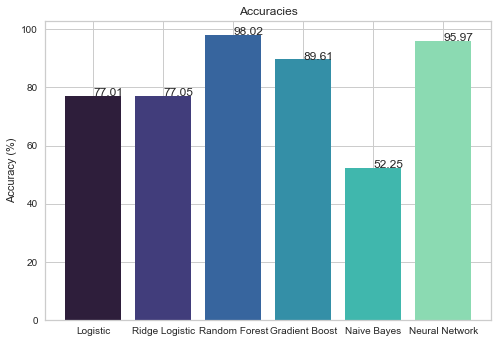

In [71]:
#Accuracy
models = 'Logistic', 'Ridge Logistic', 'Random Forest', 'Gradient Boost', 'Naive Bayes', 'Neural Network'
accuracies = [77.01, 77.05, 98.02, 89.61, 52.25, 95.97]

colors = sns.color_palette("mako", as_cmap=False)

def addlabels(models,accuracies):
    for i in range(len(models)):
        plt.text(i,accuracies[i],accuracies[i])

plt.bar(models, accuracies, align='center', color=colors)
addlabels(models, accuracies)
plt.xticks(models)
plt.ylabel('Accuracy (%)')
plt.title('Accuracies')
plt.show()

In [141]:
#AUC&F-Score
models = ['Logistic', 'Ridge Logistic', 'Random Forest', 'Gradient Boost', 'Naive Bayes', 'Neural Network']
ROC_AUC = [0.57, 0.57, 0.53, 0.58, 0.50, 0.52]
f1_micro = [0.89, 0.89, 0.92, 0.89, 0.47, 0.96]
f1_macro = [0.29, 0.29, 0.28, 0.30, 0.18, 0.27]

data = {'Models': models, 'ROC/AUC Score': ROC_AUC, 'Micro F1-Score': f1_micro, 'Macro F1-Score': f1_macro}

pd.DataFrame(data=data).set_index('Models').transpose()

Models,Logistic,Ridge Logistic,Random Forest,Gradient Boost,Naive Bayes,Neural Network
ROC/AUC Score,0.57,0.57,0.53,0.58,0.50,0.52
Micro F1-Score,0.89,0.89,0.92,0.89,0.47,0.96
Macro F1-Score,0.29,0.29,0.28,0.30,0.18,0.27


In [58]:
from sklearn.ensemble import RandomForestClassifier

classifiers = [RandomForestClassifier(n_estimators = 500),
               RandomForestClassifier(n_estimators = 500, min_samples_leaf=5000)]

In [59]:
classes = "cancelled","diverted","delayed","on-schedule"
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

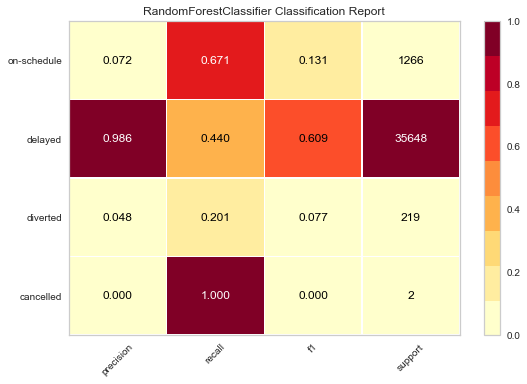

In [60]:
visualization =[CR_viz()]

In [ ]:
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)

In [ ]:
visualization =[CM_viz()]

In [ ]:
#For prediction insights
X_test['FlightStatus']=prediction_rf
X_test

In [ ]:
novemberin = X_test[['Month_11','FlightStatus']]
november = novemberin.loc[novemberin['Month_11'] == 1]
november['FlightStatus'].value_counts()

In [ ]:
decemberin = X_test[['Month_12','FlightStatus']]
december = decemberin.loc[decemberin['Month_12'] == 1]
december['FlightStatus'].value_counts()

In [ ]:
janin = X_test[['Month_1','FlightStatus']]
jan = janin.loc[janin['Month_1'] == 1]
jan['FlightStatus'].value_counts()

In [ ]:
febin = X_test[['Month_2','FlightStatus']]
feb = febin.loc[febin['Month_2'] == 1]
feb['FlightStatus'].value_counts()

In [ ]:
delays = X_test.loc[X_test['FlightStatus'] == 2]
delays.loc['Total',:]= delays.sum(axis=0)
dests = [col for col in delays.columns if 'Dest' in col]
df = delays[dests]
destination = df.transpose()
destination.sort_values('Total', ascending = False)